## Running all 4 types of Classifiers

Code is based off of Guangyuan's Tutorial



### Mount the google drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/c147_project/data')

Mounted at /content/drive


In [ ]:
% pwd 

'/content/drive/My Drive/c147_project/data'

### Utils

In [ ]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Import all the packages here

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
import time

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

### 1. Data loader

#### Load npy files

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769


print('y_train_valid', y_train_valid[:10])

# copy numpy data to tensor
X_train_valid_tensor = torch.from_numpy(X_train_valid).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_valid).float().long().to(device) # do not forget .long()

X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().long().to(device) # do not forget .long()

# # convert int labels to one hot labels
# y_train_valid_tensor = nn.functional.one_hot(y_train_valid_tensor)
# print('y_train_valid_onehot', y_train_valid_tensor[:10])


y_train_valid [2 3 0 0 0 0 2 1 3 3]


#### Show shape of data

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


#### Torch dataloader

In [ ]:
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        return len(self.subset)



def moving_average(x, w):
    """
    Simple 1d moving average using numpy

    :input x: 1d np array
    :input w: size of moving average filter
    returns np array with applied moving average
    """
    return np.convolve(x, np.ones(w), 'valid') / w


class eegData(Dataset):
    """
    PyTorch style dataset to be loaded into torch data loader for training

    provides simple functionality

    """
    def __init__(self, X_subset, y_subset, device=torch.device('cpu'), preprocessing_params={}):
        """
        :input data_file_name: file path of the data --> DEPRECATED!
        :input label_file_name: file path of the labels --> DEPRECATED!
        :input Dataset: the Dataset containing (X, y) 
        :input validation_size: size of validation (percentage given to validation)
        :input device: specify if CUDA or GPU
        :input preprocessing_params:
            'subsample': int on the size of step of the subsampling
            'mov_avg': int on the size of the moving average window
            'trim': how many of the last indices will be trimmed off
        """
        subsample = preprocessing_params.get('subsample', 1) # we can increase our trial count
        mov_avg_window = preprocessing_params.get('mov_avg', 1) # limit ourselves to 2115
        trimming = preprocessing_params.get('trim', 0) # how much you want to trim
        
        # !!!! Don't load the file anymore!!!
        # eeg_data = np.load(data_file_name)
        # label_data = np.load(label_file_name) - 769
        
        # Unpack the eeg and labels
        eeg_data, label_data = X_subset, y_subset
        self.device = device
        

        # remove the last x amount of time steps
        trimmed_indices = eeg_data.shape[2] - trimming 
        eeg_data = eeg_data[:, :, :trimmed_indices].copy()

        #begin_subsample
        stack_eeg_data = []
        stack_label_data = []
        for i in range(subsample):
            sampled_eeg_data = eeg_data[:, :, i::subsample].copy()
            stack_label_data.append(label_data.copy())
            stack_eeg_data.append(sampled_eeg_data)

        eeg_data = np.vstack(stack_eeg_data)
        label_data = np.concatenate(stack_label_data)

        # begin applying moving_average
        eeg_data = np.apply_along_axis(func1d=moving_average, axis=2, arr=eeg_data, w=mov_avg_window)


        self.eeg_data = torch.from_numpy(eeg_data).float().to(self.device)
        self.label_data = torch.from_numpy(label_data).float().long().to(self.device)
        self.mov_avg_window = mov_avg_window 
        self.trim = trimming 
        self.sampling = subsample

    def __len__(self):
        assert self.eeg_data.shape[0] == self.label_data.shape[0]
        return self.eeg_data.shape[0]


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()

        sample = {}
        sample['data'] = self.eeg_data[idx]
        sample['label'] = self.label_data[idx]

        return sample


# train_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 

# split train and val
# lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
# subset_train, subset_val = random_split(init_dataset, lengths) 

train_data = eegData(
    X_train_valid, y_train_valid, preprocessing_params={'trim': 400, 'subsample':6}, device=device)

test_data = eegData(
    X_test, y_test, preprocessing_params={'trim': 400, 'subsample':6}, device=device)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
}

### 2. Model
We also implement Shallow ConvNet as an example (figure credited to Johanns's keras slides).

In [ ]:
# Set these params and avoid hardcoded #s later on...
# Number of timestamps we're using
num_timestamps = 100

class FCValidator(nn.Module):
  """
  simple FC net that classifies the input data

  Consists of 3 fully connected layers with batch norm and relu

  """

  def __init__(self, input_channels, seq_length, classes, hidden_dims):
    super(FCValidator, self).__init__()
    self.input_dim = input_channels
    assert len(hidden_dims) == 3
    self.main = nn.Sequential(
        nn.Linear(input_channels * seq_length, hidden_dims[0]),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(hidden_dims[0]),
        nn.Dropout(0.2),
        nn.Linear(hidden_dims[0], hidden_dims[1]),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(hidden_dims[1]),
        nn.Dropout(0.2),
        nn.Linear(hidden_dims[1], hidden_dims[2]),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(hidden_dims[2]),
        nn.Linear(hidden_dims[2], classes),
        
        nn.Softmax(dim=1)
    )


  def forward(self, x):
    x = x.reshape(x.shape[0], -1)
    return self.main(x)


class CNNValidator(nn.Module):
  """
  Simple network that uses 2 Convolution + max pool layers + relu, 1 conv + relu layer + 1 linear
  """
  def __init__(self, input_channels, classes, hidden_dims):
    super(CNNValidator, self).__init__()
    assert len(hidden_dims) == 3
    self.main = nn.Sequential(
        nn.Conv1d(22, hidden_dims[0], 3, stride=2, padding=2),
        nn.ReLU(True),
        nn.MaxPool1d(3, 1),
        nn.Conv1d(hidden_dims[0], hidden_dims[1], 3, stride=2, padding=2),
        nn.ReLU(True),
        nn.MaxPool1d(3, 1), 
        nn.Conv1d(hidden_dims[1], hidden_dims[2], 3, stride=2, padding=2),
        nn.ReLU(True)
    )
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_dims[2]*13, classes),
        nn.Softmax(dim=1)
        )
    
  def forward(self, x):
    a = self.main(x)
    return self.linear(a)


class ConvLSTMValidator(nn.Module):
  """
  mix of cnn with conv and lstm
  """
  def __init__(self, input_channels, classes, hidden_dims):
    super(ConvLSTMValidator, self).__init__()
    assert len(hidden_dims) == 3
    self.main = nn.Sequential(
        nn.Conv1d(input_channels, hidden_dims[0], 3, stride=2, padding=2),
        nn.ReLU(True),
        nn.MaxPool1d(2, 1),
        nn.Conv1d(hidden_dims[0], hidden_dims[1], 3, stride=2, padding=2),
        nn.ReLU(True),
        nn.Dropout(0.2)
        )
    self.lstm = nn.LSTM(hidden_dims[1], hidden_dims[2], batch_first=True)
    self.out = nn.Sequential(
        nn.Flatten(),
        nn.Linear(26 * hidden_dims[2], classes),
        nn.Softmax(dim=1)
    )


  def forward(self, x):
    batch = x.shape[0]
    out_x = self.main(x)
    out_x_reshaped = out_x.permute(0, 2, 1)
    out_lstm, _ = self.lstm(out_x_reshaped)

    return self.out(out_lstm)


class ConvGRUValidator(nn.Module):
  """
  mix of cnn with conv and lstm
  """
  def __init__(self, input_channels, classes, hidden_dims):
    super(ConvGRUValidator, self).__init__()
    assert len(hidden_dims) == 3
    self.main = nn.Sequential(
        nn.Conv1d(input_channels, hidden_dims[0], 3, stride=2, padding=2),
        nn.ReLU(True),
        nn.MaxPool1d(3, 1),
        nn.Conv1d(hidden_dims[0], hidden_dims[1], 3, stride=2, padding=2),
        nn.ReLU(True),
        nn.Dropout(0.2)
        )
    self.gru = nn.GRU(hidden_dims[1], hidden_dims[2], batch_first=True)
    self.out = nn.Sequential(
        nn.Flatten(),
        nn.Linear(26 * hidden_dims[2], classes),
        nn.Softmax(dim=1)
    )


  def forward(self, x):
    batch = x.shape[0]
    out_x = self.main(x)
    out_x_reshaped = out_x.permute(0, 2, 1)
    out_gru, _ = self.gru(out_x_reshaped)
    return self.out(out_gru)


class LSTMCNNValidator(nn.Module):
  """
  100 timestamps
  22 sequences of data
  Input: (batch_size, 22, 100)
  """
  def __init__(self):
    super(LSTMCNNValidator, self).__init__()
    self.rnn = nn.LSTM(22, 10, 2, batch_first=True) 
    self.convMaxPool = nn.Sequential(
        # in_channels, out_channels, kernal, stride, padding
        nn.ConvTranspose1d(100, 10, 5, 2, 2, bias=False),
        nn.MaxPool1d(4),
        nn.ReLU(True)
    )
    self.convBatch = nn.Sequential(
        nn.ConvTranspose1d(10, 5, 3, 2, 1, bias = False),
        nn.BatchNorm1d(5),
        nn.ReLU(True)
    )
    self.seq = nn.Sequential(
        nn.Linear(5 * 7, 4),
        nn.Softmax(dim=1)
    )

  def forward(self,input):
    # Input: (B, 22, 100)
    x = input.permute(0, 2, 1)
    x, _ = self.rnn(x)
    x = self.convMaxPool(x)
    x = self.convBatch(x)
    x = x.view(-1, 5 * 7)
    x = self.seq(x)
    return x

### 3. Train scripts

#### Train function

In [ ]:

def train_model(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'test']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for batch in dataloaders[phase]:
          inputs = batch['data']
          labels = batch['label']
          batch_idx += 1
          
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later

            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))


        prefix = ''
        if phase == 'test':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

#### Main 

Running 4 different models

In [ ]:
num_epochs = 300
lr = 1e-4

weight_decay = 0.015  # weight decay to alleviate overfiting

model_FC = FCValidator(22, 100, 4, [1500, 1000, 500]).to(device)

print(model_FC)
count = count_parameters(model_FC)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_FC.parameters(), lr = lr, weight_decay=weight_decay)

FCValidator(
  (main): Sequential(
    (0): Linear(in_features=2200, out_features=1500, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1500, out_features=1000, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=1000, out_features=500, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=500, out_features=4, bias=True)
    (12): Softmax(dim=1)
  )
)
model parameters amount 5311004


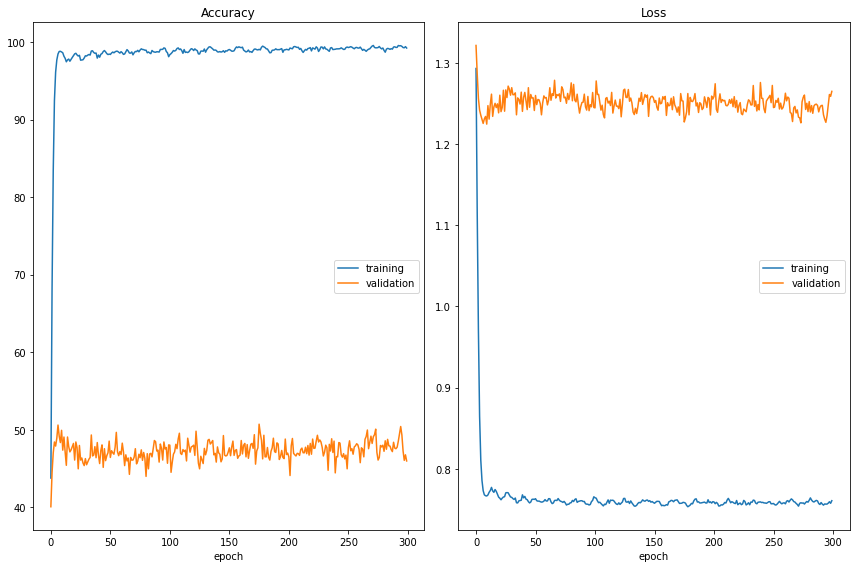

Accuracy
	training         	 (min:   43.767, max:   99.559, cur:   99.228)
	validation       	 (min:   40.068, max:   50.715, cur:   45.974)
Loss
	training         	 (min:    0.753, max:    1.293, cur:    0.761)
	validation       	 (min:    1.224, max:    1.321, cur:    1.265)


In [ ]:
model_FC=train_model(model_FC, optimizer, num_epochs=num_epochs)

In [ ]:
num_epochs = 300
lr = 1e-3
weight_decay = 0.015  # weight decay to alleviate overfiting

model_CNN = CNNValidator(22, 4, hidden_dims=[100, 20, 4]).to(device)

print(model_CNN)
count = count_parameters(model_CNN)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr = lr, weight_decay=weight_decay)

CNNValidator(
  (main): Sequential(
    (0): Conv1d(22, 100, kernel_size=(3,), stride=(2,), padding=(2,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(100, 20, kernel_size=(3,), stride=(2,), padding=(2,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(20, 4, kernel_size=(3,), stride=(2,), padding=(2,))
    (7): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=52, out_features=4, bias=True)
    (2): Softmax(dim=1)
  )
)
model parameters amount 13176


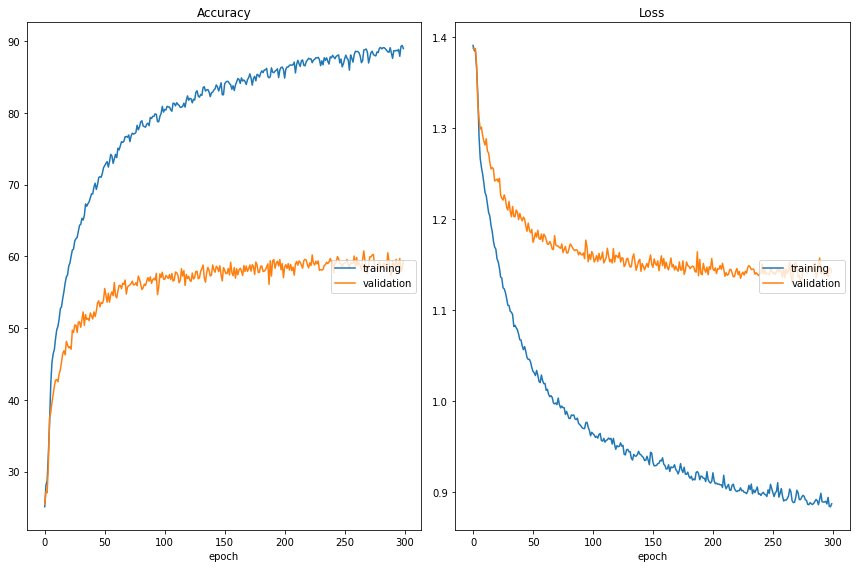

Accuracy
	training         	 (min:   25.099, max:   89.401, cur:   88.960)
	validation       	 (min:   25.395, max:   60.760, cur:   59.330)
Loss
	training         	 (min:    0.884, max:    1.391, cur:    0.887)
	validation       	 (min:    1.130, max:    1.388, cur:    1.142)


In [ ]:
model_CNN=train_model(model_CNN, optimizer, num_epochs=num_epochs)

In [ ]:
num_epochs = 300
lr = 1e-3
# define the hyperparamters
weight_decay = 0.015  # weight decay to alleviate overfiting

model_CLSTM = ConvLSTMValidator(22, 4, hidden_dims=[44, 88, 11]).to(device)

print(model_CLSTM)
count = count_parameters(model_CLSTM)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CLSTM.parameters(), lr = lr, weight_decay=weight_decay)


ConvLSTMValidator(
  (main): Sequential(
    (0): Conv1d(22, 44, kernel_size=(3,), stride=(2,), padding=(2,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(44, 88, kernel_size=(3,), stride=(2,), padding=(2,))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(88, 11, batch_first=True)
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=286, out_features=4, bias=True)
    (2): Softmax(dim=1)
  )
)
model parameters amount 20244


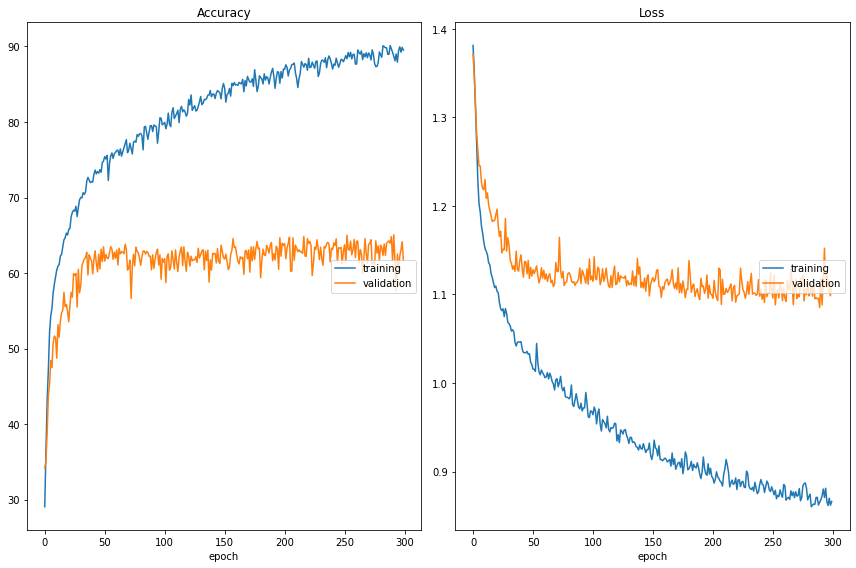

Accuracy
	training         	 (min:   29.054, max:   90.134, cur:   89.519)
	validation       	 (min:   34.199, max:   65.087, cur:   61.625)
Loss
	training         	 (min:    0.860, max:    1.381, cur:    0.866)
	validation       	 (min:    1.085, max:    1.372, cur:    1.114)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model_CLSTM=train_model(model_CLSTM, optimizer, num_epochs=num_epochs)

In [ ]:
num_epochs = 500
lr = 1e-3
# define the hyperparamters
weight_decay = 0.0015  # weight decay to alleviate overfiting

model_CGRU = ConvGRUValidator(22, 4, hidden_dims=[44, 88, 11]).to(device)
print(model_CGRU)
count = count_parameters(model_CGRU)

print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CGRU.parameters(), lr = lr, weight_decay=weight_decay)

ConvGRUValidator(
  (main): Sequential(
    (0): Conv1d(22, 44, kernel_size=(3,), stride=(2,), padding=(2,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(44, 88, kernel_size=(3,), stride=(2,), padding=(2,))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (gru): GRU(88, 11, batch_first=True)
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=286, out_features=4, bias=True)
    (2): Softmax(dim=1)
  )
)
model parameters amount 19133


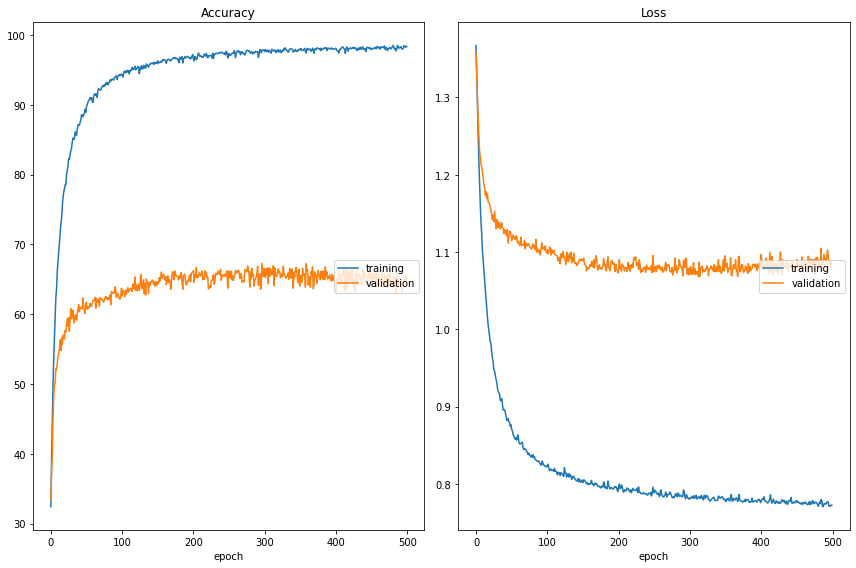

Accuracy
	training         	 (min:   32.419, max:   98.503, cur:   98.322)
	validation       	 (min:   33.446, max:   67.306, cur:   64.748)
Loss
	training         	 (min:    0.771, max:    1.367, cur:    0.773)
	validation       	 (min:    1.068, max:    1.359, cur:    1.085)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model_CGRU=train_model(model_CGRU, optimizer, num_epochs=num_epochs)


In [ ]:
torch.save(model_FC.state_dict(), 'validator-2021-03-09-fc.pt')
torch.save(model_CNN.state_dict(), 'validator-2021-03-09-cnn.pt')
torch.save(model_CLSTM.state_dict(), 'validator-2021-03-09-cnnlstm.pt')
torch.save(model_CGRU.state_dict(), 'validator-2021-03-09-cnngru.pt')

# Testing models on Generated data


In [ ]:
class Validator:
  def __init__(self, model, Generated_samples, labels):
    self.model = model
    self.X = Generated_samples
    self.y = labels

    self.test_acc = 0.0
  
  def calculate_val_acc(self):
    outputs = self.model(self.X)
   
    _, predicted = torch.max(outputs, 1)
    print('*****')
    predicted = predicted.view(-1, 1)
    total = predicted.size(0) * predicted.size(1)
    correct = (predicted == self.y).sum().item()
    self.test_acc = (correct / total)
    print("Accuracy on data: ", self.test_acc)


## Loading models

In [ ]:
model_FC = FCValidator(22, 100, 4, [1500, 1000, 500]).to(device)
model_FC.load_state_dict(torch.load('validator-2021-03-09-fc.pt'))
model_CNN = CNNValidator(22, 4, hidden_dims=[100, 20, 4]).to(device)
model_CNN.load_state_dict(torch.load('validator-2021-03-09-cnn.pt'))
model_CLSTM = ConvLSTMValidator(22, 4, hidden_dims=[44, 88, 11]).to(device)
model_CLSTM.load_state_dict(torch.load('validator-2021-03-09-cnnlstm.pt'))
model_CGRU = ConvGRUValidator(22, 4, hidden_dims=[44, 88, 11]).to(device)
model_CGRU.load_state_dict(torch.load('validator-2021-03-09-cnngru.pt'))

model_LSTMCNN = LSTMCNNValidator().to(device)
model_LSTMCNN.load_state_dict(torch.load('validator-utsav-lstm-cnn.pt'))


<All keys matched successfully>

## Testing all models on all generated data

In [ ]:

models = {
    'FC': model_FC,
    'CNN': model_CNN,
    'CLSTM': model_CLSTM,
    'CGRU': model_CGRU,
    'LSTMCNN': model_LSTMCNN
}

data = [
        'LSTM-CNN',
        'LSTM-LSTM',
        'GRU-CNN',
        'GRU-LSTM',
        'CNN-CNN',
        'CNN+LSTM-CNN'
]

for key in models:
  model = models[key]
  print("====================")
  print("Results for " + key + ": ")
  print()
  for gan in data:
    print("Testing on data from " + gan + " GAN")
    X_test = np.load("../Models/Fake_Data/" + gan + "_data.npy")
    y_test = np.load("../Models/Fake_Data/" + gan + "_labels.npy")
    X_test_tensor = torch.from_numpy(X_test).float().to(device)
    y_test_tensor = torch.from_numpy(y_test).float().long().to(device) # do not forget .long()
    print(y_test_tensor.shape)
    # Load in the model
    # model = ShallowConv(1, 4).to(device)
    # model.load_state_dict(torch.load('validator-2021-03-04.pt'))
    model.eval()

    validator = Validator(model, X_test_tensor, y_test_tensor)
    validator.calculate_val_acc()
    print()







# # print(X_test.shape)
# # plt.plot(X_test[0][0])
# # plt.axis([0, 100, -10, 10])
# # plt.show()
# # # interpolate sample
# X_test_scaled = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# for i in range(X_test.shape[0]):
#   for j in range(22):
#     # xloc = np.arange(100)
#     # new_xloc = np.linspace(0, 100, 600)
#     # new_data = np.interp(new_xloc, xloc, X_test[i][j][:])
#     X_test_scaled[i][j][:] = X_test[i][j][:] * 600
  
# # plt.plot(X_test_interp[0][0])

# # print(y_test.shape)

# # # copy numpy data to tensor
# X_test_tensor = torch.from_numpy(X_test_scaled).float().to(device)
# y_test_tensor = torch.from_numpy(y_test).float().long().to(device) # do not forget .long()
# print(y_test_tensor.shape)
# # Load in the model
# # model = ShallowConv(1, 4).to(device)
# # model.load_state_dict(torch.load('validator-2021-03-04.pt'))
# model.eval()

# validator = Validator(model, X_test_tensor, y_test_tensor)
# validator.calculate_val_acc()

Results for FC: 

Testing on data from LSTM-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.263

Testing on data from LSTM-LSTM GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.286

Testing on data from GRU-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.233

Testing on data from GRU-LSTM GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.256

Testing on data from CNN-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.229

Testing on data from CNN+LSTM-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.247

Results for CNN: 

Testing on data from LSTM-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.291

Testing on data from LSTM-LSTM GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.222

Testing on data from GRU-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.34

Testing on data from GRU-LSTM GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0.362

Testing on data from CNN-CNN GAN
torch.Size([1000, 1])
*****
Accuracy on data:  0